In [1]:
import numpy as np 
import pandas as pd 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
!pip install scikit-learn==1.4.2 imbalanced-learn==0.12.2
!pip install --upgrade ctgan

/kaggle/input/Indian Liver Patient Dataset (ILPD).csv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7

### **Project Overview**

This notebook is an extension of Replication of Liver Disease Classification - KNN, where I replicated key parts of the paper - “Tabular Data Generation to Improve Classification of Liver Disease Diagnosis” by _Mohammad Alauthman et al._ - but used just KNN. 

Here I would be doing carrrying out the previous objectves while using Artificial Neural Networks (ANN)

### **Replication Objective**

In this notebook, I will:

1.  Progressively apply and compare several supervised machine learning algorithms — KNN, Logistic Regression, Decision Tree, SVM, and ANN — on the ILPD dataset.
2.  Evaluate model performance before and after applying SMOTE to assess the impact of oversampling on classification quality.
3.  Reproduce and analyze key evaluation metrics, including Accuracy, Precision, Recall, F1-Score, and ROC-AUC, to verify or challenge the findings reported in the original study.

In [2]:
path = "/kaggle/input/Indian Liver Patient Dataset (ILPD).csv"
data=pd.read_csv(path)

cols = ['Age','Gender','TB_total_bilirubin', 'DB_Direct_Bilirubin',
       'Alkphos_Alkaline_Phosphotase', 'Sgpt_Alamine_Aminotransferase',
       'Sgot_Aspartate_Aminotransferase', 'TP_Total_Protiens', 'ALB_Albumin',
       'A/G_Ratio','Selector']
data.columns = cols
data.head()

,Age,Gender,TB_total_bilirubin,DB_Direct_Bilirubin,Alkphos_Alkaline_Phosphotase,Sgpt_Alamine_Aminotransferase,Sgot_Aspartate_Aminotransferase,TP_Total_Protiens,ALB_Albumin,A/G_Ratio,Selector
0,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,1


In [3]:
# one hot encode categorical data
data = pd.get_dummies(data)
data.head()

,Age,TB_total_bilirubin,DB_Direct_Bilirubin,Alkphos_Alkaline_Phosphotase,Sgpt_Alamine_Aminotransferase,Sgot_Aspartate_Aminotransferase,TP_Total_Protiens,ALB_Albumin,A/G_Ratio,Selector,Gender_Female,Gender_Male
0,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,False,True
1,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,False,True
2,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,False,True
3,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,False,True
4,46,1.8,0.7,208,19,14,7.6,4.4,1.30,1,False,True


In [4]:
# replace NaN values with mean
data['A/G_Ratio'] = data['A/G_Ratio'].fillna(data['A/G_Ratio'].mean())
data['A/G_Ratio'].isna().sum()

0

In [5]:
# set y
y = data.Selector

# Update the columns list post one hot encoding 
cols = data.columns.tolist()
cols.remove("Selector")

# set X
features = cols
X = data[features]

In [6]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.neural_network import MLPClassifier


mcc_scorer = make_scorer(matthews_corrcoef)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'mcc': make_scorer(matthews_corrcoef)
}



# Create and train the MLP Classifier
ilp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  
    activation='relu',             
    solver='adam',                 
    alpha=0.001,                  
    batch_size='auto',                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
    learning_rate='constant',     
    learning_rate_init=0.001,     
    max_iter=1000,                
    random_state=42,
    early_stopping=True,          
    validation_fraction=0.1,      
    n_iter_no_change=10           
)


# ilp_model = SVC(kernel="rbf", C=1.0, gamma="scale")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # fit + transform

skf = StratifiedKFold(n_splits=10)
cv_results = cross_validate(ilp_model, X_scaled, y, cv=skf, scoring=scoring)

# Average scores
for metric in scoring:
    print(f"Average {metric}: {cv_results['test_' + metric].mean():.3f}")


Average accuracy: 0.701
Average recall: 0.947
Average precision: 0.721
Average f1: 0.818
Average mcc: 0.075


In [7]:
# REPORTING THE FINDINGS 
# Create a dataframe with appropriate column names
smote_results = pd.DataFrame(columns=["case", "accuracy", "recall", "precision", "f1", "mcc"])

In [8]:
# retrieve the for the initial dataset metrics and add them to the df
metric_list = ["UNBALANCED"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list
smote_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.7011,0.9473,0.721,0.818,0.0746


### Augmentation with SMOTE (Synthetic Minority Oversampling Technique - SMOTE)

In [9]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print("Before SMOTE:", Counter(y))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

print("After SMOTE:", Counter(y_smote))

Before SMOTE: Counter({1: 415, 2: 167})
After SMOTE: Counter({1: 415, 2: 415})


In [10]:
# calculate with augmented data
cv_results = cross_validate(ilp_model, X_smote, y_smote, cv=skf, scoring=scoring)

# retrieve the for the initial dataset metrics and add them to the df
metric_list = ["BAL-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list
smote_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.7011,0.9473,0.7210,0.8180,0.0746
1,BAL-AUG,0.7048,0.5588,0.7878,0.6455,0.4304


In [11]:
# get current number of rows
current_count = Counter(y_smote)[1]
double = current_count * 2
triple = current_count * 3
quadrupule = current_count * 4

In [12]:
# DOUBLE THE DATA WITH SMOTE
# double y with index 1
smote_double = SMOTE(sampling_strategy={1: double}, random_state=42)  
X_double, y_double = smote_double.fit_resample(X_smote, y_smote)
print("Double SMOTE:", Counter(y_double))

# normalize index 1 and 2, effectively doubling the data
smote_double = SMOTE(random_state=42)
X_double, y_double = smote_double.fit_resample(X_double, y_double)
print("Double SMOTE:", Counter(y_double))

Double SMOTE: Counter({1: 830, 2: 415})
Double SMOTE: Counter({1: 830, 2: 830})


In [13]:
# calculate with augmented data
cv_results = cross_validate(ilp_model, X_double, y_double, cv=skf, scoring=scoring)

# retrieve the metrics for the dataset augmented 2 fold and add them to the df
metric_list = ["DD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list
print(smote_results)

         case  accuracy  recall  precision      f1     mcc
0  UNBALANCED    0.7011  0.9473     0.7210  0.8180  0.0746
1     BAL-AUG    0.7048  0.5588     0.7878  0.6455  0.4304
2      DD-AUG    0.7789  0.6831     0.8479  0.7486  0.5736


In [14]:
# TRIPLE THE DATA WITH SMOTE

# Triple the data 
smote_triple = SMOTE(sampling_strategy={1: triple}, random_state=42)  
X_triple, y_triple = smote_triple.fit_resample(X_smote, y_smote)

# normalize index 1 and 2, effectively doubling the data
smote_triple = SMOTE(random_state=42)
X_triple, y_triple = smote_double.fit_resample(X_triple, y_triple)
print("Double SMOTE:", Counter(y_triple))

Double SMOTE: Counter({1: 1245, 2: 1245})


In [15]:
# calculate with augmented data
cv_results = cross_validate(ilp_model, X_triple, y_triple, cv=skf, scoring=scoring, return_train_score=True)
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

# retrieve the metrics for the dataset augmented 3 fold and add them to the df
metric_list = ["TD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list

Training mcc: 0.7012585780589754
Validation mcc: 0.6580668587580489


In [16]:
# QUADRUPULE THE DATA WITH SMOTE

# Quadrupul data 
smote_quad = SMOTE(sampling_strategy={1: quadrupule}, random_state=42)  
X_quad, y_quad = smote_quad.fit_resample(X_smote, y_smote)

# normalize index 1 and 2, effectively Quadrupling the data
smote_quad = SMOTE(random_state=42)
X_quad, y_quad = smote_quad.fit_resample(X_quad, y_quad)

# calculate with augmented data
cv_results = cross_validate(ilp_model, X_quad, y_quad, cv=skf, scoring=scoring, return_train_score=True)

# retrieve the metrics for the dataset augmented 4x and add them to the df
metric_list = ["QD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list


# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

smote_results.head()

Training mcc: 0.7800282883560137
Validation mcc: 0.7357251926131527


,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.7011,0.9473,0.7210,0.8180,0.0746
1,BAL-AUG,0.7048,0.5588,0.7878,0.6455,0.4304
2,DD-AUG,0.7789,0.6831,0.8479,0.7486,0.5736
3,TD-AUG,0.8261,0.7704,0.8681,0.8143,0.6581
4,QD-AUG,0.8660,0.8265,0.8992,0.8603,0.7357


In [17]:
# from tabulate import tabulate
# print(tabulate(smote_results, headers="keys", tablefmt="psql"))

### Augmentation with CTGAN (Conditional Tabular Generative Adversarial Network)

In [18]:
from ctgan import CTGAN
import torch
import numpy as np
import random

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Initialize and train CTGAN
ctgan = CTGAN(epochs=400)
ctgan.fit(data)

# We already know that there is an imbalane of 248 (415-248)
synthetic_minority = ctgan.sample(248, {'Selector': 2})

# combine both the original and synthetic data sets 
balanced_data = pd.concat([data, synthetic_minority])


# generate 4x the data and select accordingly - I think its best to just generate all the data i need at once and then select them accordingly 

len_balanced = len(balanced_data)
number_to_generate = (len(balanced_data) * 4) - len_balanced
generated_difference = ctgan.sample(number_to_generate)

# combine and select 
quad_data = pd.concat([balanced_data, generated_difference])
double_data = quad_data.head(len_balanced * 2)
tripple_data = quad_data.head(len_balanced * 3)

In [19]:
# USING SMOTE AND GAN

# from ctgan import CTGAN
# import torch
# import numpy as np
# import random

# # Set seeds for reproducibility
# seed = 42
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

# discrete_columns = ['Selector', 'Gender_Female', 'Gender_Male']

# # Initialize and train CTGAN
# ctgan = CTGAN(epochs=400)
# ctgan.fit(data, discrete_columns=discrete_columns)

# # make use of the data balanced earlier with smote
# balanced_data = pd.DataFrame(X_smote, columns=X.columns)
# balanced_data['Selector'] = y_smote

# # generate 4x the data and select accordingly - I think its best to just generate all the data i need at once and then select them accordingly 

# len_balanced = len(balanced_data)
# number_to_generate = (len(balanced_data) * 4) - len_balanced
# generated_difference = ctgan.sample(number_to_generate)

# # combine and select 
# quad_data = pd.concat([balanced_data, generated_difference])
# double_data = quad_data.head(len_balanced * 2)
# tripple_data = quad_data.head(len_balanced * 3)


In [20]:
y = quad_data.Selector
print("After GAN:", Counter(y))

After GAN: Counter({1: 2781, 2: 539})


In [21]:
# BALANCED DATA 

# set y
y = balanced_data.Selector

# set z 
cols = balanced_data.columns.tolist()
cols.remove("Selector")
features = cols
X = balanced_data[features]
X = scaler.fit_transform(X)  # fit + transform

# Create a dataframe with appropriate column names
gan_results = pd.DataFrame(columns=["case", "accuracy", "recall", "precision", "f1", "mcc"])

# calculate with augmented data
cv_results = cross_validate(ilp_model, X, y, cv=skf, scoring=scoring, return_train_score=True)

# retrieve the metrics for the balanced dataset and add them to the results df
metric_list = ["BAL-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

gan_results.loc[len(gan_results)] = metric_list

gan_results.head()

,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7482,0.9952,0.7497,0.8552,0.0567


In [22]:
# 2x DATA 

# set y
y = double_data.Selector

# set z 
features = cols
X = double_data[features]
X = scaler.fit_transform(X)  # fit + transform

# calculate with augmented data
cv_results = cross_validate(ilp_model, X, y, cv=skf, scoring=scoring, return_train_score=True)

# retrieve the metrics for the dataset and add them to the results df
metric_list = ["DD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

gan_results.loc[len(gan_results)] = metric_list


# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

gan_results.head()

Training mcc: 0.13273053988373493
Validation mcc: -0.0009231401159868619


,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7482,0.9952,0.7497,0.8552,0.0567
1,DD-AUG,0.7922,0.9654,0.8141,0.8822,-0.0009


In [23]:
# 3x DATA 

# set y
y = tripple_data.Selector

# set z 
features = cols
X = tripple_data[features]
X = scaler.fit_transform(X)  # fit + transform

# calculate with augmented data
cv_results = cross_validate(ilp_model, X, y, cv=skf, scoring=scoring, return_train_score=True)

# retrieve the metrics for the dataset and add them to the results df
metric_list = ["TD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

gan_results.loc[len(gan_results)] = metric_list


# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

gan_results.head()

Training mcc: 0.06287498012854878
Validation mcc: 0.034197809213966826


,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7482,0.9952,0.7497,0.8552,0.0567
1,DD-AUG,0.7922,0.9654,0.8141,0.8822,-0.0009
2,TD-AUG,0.8209,0.9779,0.8358,0.9000,0.0342


In [24]:
# 4x DATA 

# set y
y = quad_data.Selector

# set z 
features = cols
X = quad_data[features]
X = scaler.fit_transform(X)  # fit + transform

# calculate with augmented data
cv_results = cross_validate(ilp_model, X, y, cv=skf, scoring=scoring, return_train_score=True)

# retrieve the metrics for the dataset and add them to the results df
metric_list = ["QD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

gan_results.loc[len(gan_results)] = metric_list


# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

Training mcc: 0.05656694958497116
Validation mcc: 0.0


In [25]:
y = quad_data.Selector
print("After GAN:", Counter(y))

After GAN: Counter({1: 2781, 2: 539})


In [26]:
from tabulate import tabulate
print(tabulate(gan_results, headers="keys", tablefmt="psql"))

+----+---------+------------+----------+-------------+--------+---------+
|    | case    |   accuracy |   recall |   precision |     f1 |     mcc |
|----+---------+------------+----------+-------------+--------+---------|
|  0 | BAL-AUG |     0.7482 |   0.9952 |      0.7497 | 0.8552 |  0.0567 |
|  1 | DD-AUG  |     0.7922 |   0.9654 |      0.8141 | 0.8822 | -0.0009 |
|  2 | TD-AUG  |     0.8209 |   0.9779 |      0.8358 | 0.9    |  0.0342 |
|  3 | QD-AUG  |     0.8377 |   1      |      0.8377 | 0.9117 |  0      |
+----+---------+------------+----------+-------------+--------+---------+


In [27]:
gan_results.head()

,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7482,0.9952,0.7497,0.8552,0.0567
1,DD-AUG,0.7922,0.9654,0.8141,0.8822,-0.0009
2,TD-AUG,0.8209,0.9779,0.8358,0.9000,0.0342
3,QD-AUG,0.8377,1.0000,0.8377,0.9117,0.0000


In [28]:
smote_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.7011,0.9473,0.7210,0.8180,0.0746
1,BAL-AUG,0.7048,0.5588,0.7878,0.6455,0.4304
2,DD-AUG,0.7789,0.6831,0.8479,0.7486,0.5736
3,TD-AUG,0.8261,0.7704,0.8681,0.8143,0.6581
4,QD-AUG,0.8660,0.8265,0.8992,0.8603,0.7357


In [29]:
# Save Both Files 
import pandas as pd


smote_results.to_csv("gan_results.csv", index=False) 
smote_results.to_csv("smote_results.csv", index=False) 

Confusion Matrix:
[[2781    0]
 [ 539    0]]


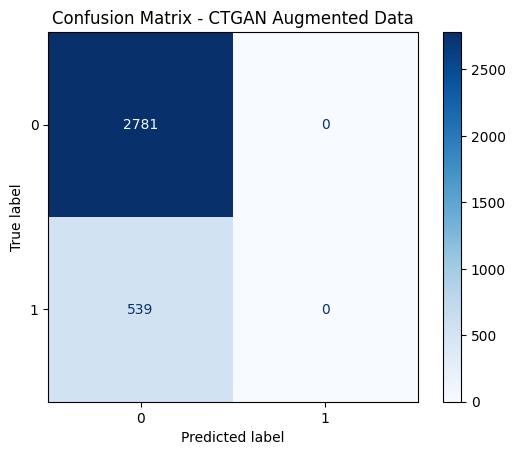

Training mcc: 0.05656694958497116
Validation mcc: 0.0

Confusion Matrix Details:
True Negatives: 2781
False Positives: 0
False Negatives: 539
True Positives: 0
Accuracy: 0.8377


In [30]:
# Get predictions for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt  # ADD THIS IMPORT

# Get out-of-fold predictions for confusion matrix
y_pred = cross_val_predict(ilp_model, X, y, cv=skf)

# Calculate and display confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CTGAN Augmented Data')
plt.show()

# retrieve the metrics for the dataset and add them to the results df
metric_list = ["QD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

gan_results.loc[len(gan_results)] = metric_list

# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

# Additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Details:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")

Confusion Matrix for QUAD Data:
[[1372  288]
 [ 157 1503]]


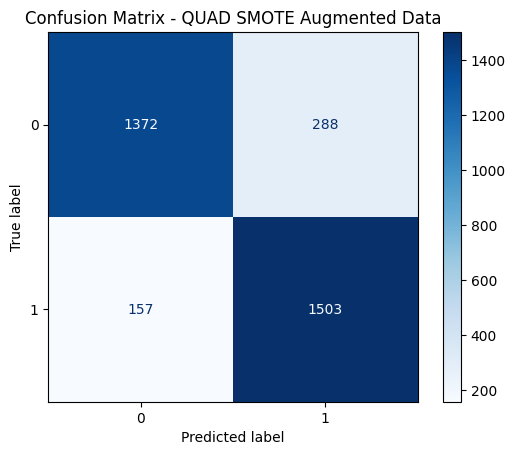


Confusion Matrix Details:
True Negatives: 1372
False Positives: 288
False Negatives: 157
True Positives: 1503
Accuracy: 0.8660
Precision: 0.8392
Recall: 0.9054

Overfitting Check:
Training mcc: 0.7800282883560137
Validation mcc: 0.7357251926131527


In [31]:
# QUADRUPULE THE DATA WITH SMOTE

# Quadrupul data 
smote_quad = SMOTE(sampling_strategy={1: quadrupule}, random_state=42)  
X_quad, y_quad = smote_quad.fit_resample(X_smote, y_smote)

# normalize index 1 and 2, effectively Quadrupling the data
smote_quad = SMOTE(random_state=42)
X_quad, y_quad = smote_quad.fit_resample(X_quad, y_quad)

# calculate with augmented data
cv_results = cross_validate(ilp_model, X_quad, y_quad, cv=skf, scoring=scoring, return_train_score=True)

# ADD CONFUSION MATRIX HERE - USING QUAD DATA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

# Get out-of-fold predictions for confusion matrix - USING QUAD DATA
y_pred = cross_val_predict(ilp_model, X_quad, y_quad, cv=skf)

# Calculate and display confusion matrix - USING QUAD DATA
cm = confusion_matrix(y_quad, y_pred)
print("Confusion Matrix for QUAD Data:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - QUAD SMOTE Augmented Data')
plt.show()

# Additional metrics from confusion matrix
if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix Details:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
    print(f"Precision: {tp / (tp + fp):.4f}" if (tp + fp) > 0 else "Precision: undefined")
    print(f"Recall: {tp / (tp + fn):.4f}" if (tp + fn) > 0 else "Recall: undefined")

# retrieve the metrics for the dataset augmented 4x and add them to the df
metric_list = ["QD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list

# Compare traning and validation mcc to check for overfitting 
print("\nOverfitting Check:")
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

## Notes
### 22-11-25, 08:37

### FINAL RESULTS:

**ANN WITH SMOTE** 

| case       | accuracy | recall | precision | f1     | mcc    |
| ---------- | -------- | ------ | --------- | ------ | ------ |
| UNBALANCED | 0.7011   | 0.9473 | 0.7210    | 0.8180 | 0.0746 |
| BAL-AUG    | 0.7048   | 0.5588 | 0.7878    | 0.6455 | 0.4304 |
| DD-AUG     | 0.7789   | 0.6831 | 0.8479    | 0.7486 | 0.5736 |
| TD-AUG     | 0.8261   | 0.7704 | 0.8681    | 0.8143 | 0.6581 |
| QD-AUG     | 0.8660   | 0.8265 | 0.8992    | 0.8603 | 0.7357 |


**ANN WITH CTGAN**
| case    | accuracy | recall | precision | f1     | mcc     |
| ------- | -------- | ------ | --------- | ------ | ------- |
| BAL-AUG | 0.7482   | 0.9952 | 0.7497    | 0.8552 | 0.0567  |
| DD-AUG  | 0.7922   | 0.9654 | 0.8141    | 0.8822 | -0.0009 |
| TD-AUG  | 0.8209   | 0.9779 | 0.8358    | 0.9000 | 0.0342  |
| QD-AUG  | 0.8377   | 1.0000 | 0.8377    | 0.9117 | 0.0000  |


### SUMMARY:

Predictions using the ANN augmented with CTGAN produced results comparable to SMOTE augmentation. Interestingly, it had an MCC of 0 but a recall of 100% after generating four times the initial data. This shows that the CTGAN-augmented dataset was heavily imbalanced, causing the model to predict “true” for all cases—hence the perfect recall. Accuracy and precision still appeared high because there were overwhelming numbers of True Positives and only a few False Positives, but no True Negatives or False Negatives. The MCC was the giveaway: the absence of true or false negatives inevitably drives MCC to 0.

Examining the ANN + SMOTE results, Initially, the model behaves similarly to the GAN setup, showing extremely high recall (99%) and an MCC close to zero (0.05), indicating that the model is still essentially guessing “positive” most of the time. However, once the data is properly balanced with SMOTE, the MCC rises to 0.4 and recall drops almost by half, as the model begins to make negative predictions—leading to more False Negatives and False Positives. As the model continues training on more balanced data, recall improves again without a corresponding drop in MCC, suggesting the dataset remains consistently balanced.

In the end, the final metrics tell the full story: an accuracy of 0.87, recall of 0.83, precision of 0.90, and F1 score of 0.86, while the MCC rises significantly to 0.74.